In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-duplicate-questions-detection/quora_duplicate_questions.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
data=pd.read_csv("/kaggle/input/quora-duplicate-questions-detection/quora_duplicate_questions.csv")
data.head(5)

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
4,4,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345036 entries, 0 to 345035
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         345036 non-null  int64 
 1   id            345036 non-null  int64 
 2   qid1          345036 non-null  int64 
 3   qid2          345036 non-null  int64 
 4   question1     345035 non-null  object
 5   question2     345034 non-null  object
 6   is_duplicate  345036 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 18.4+ MB


In [5]:
data.groupby("is_duplicate").count()

,index,id,qid1,qid2,question1,question2
is_duplicate,,,,,,
0,208756,208756,208756,208756,208755,208754
1,136280,136280,136280,136280,136280,136280


In [6]:
(data['is_duplicate'].value_counts()/data['is_duplicate'].count())*100

is_duplicate
0    60.502672
1    39.497328
Name: count, dtype: float64

<Axes: xlabel='is_duplicate'>

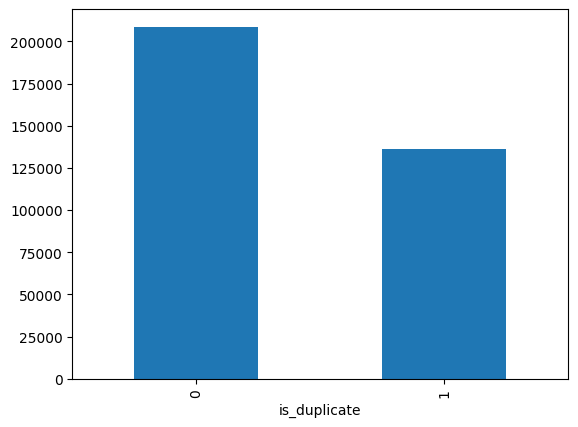

In [7]:
data["is_duplicate"].value_counts().plot(kind="bar")

In [8]:
data.dropna(inplace=True)

In [9]:
new_data=data[["question1","question2"]]
new_data

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Should I buy tiago?,What keeps childern active and far from phone ...
4,How can I be a good geologist?,What should I do to be a great geologist?
...,...,...
345031,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...
345032,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...
345033,Do you believe there is life after death?,Is it true that there is life after death?
345034,What is one coin?,What's this coin?


In [10]:
data.isnull().sum()

index           0
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [11]:

# Repeated questions

qid = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 675521
Number of questions getting repeated 10472


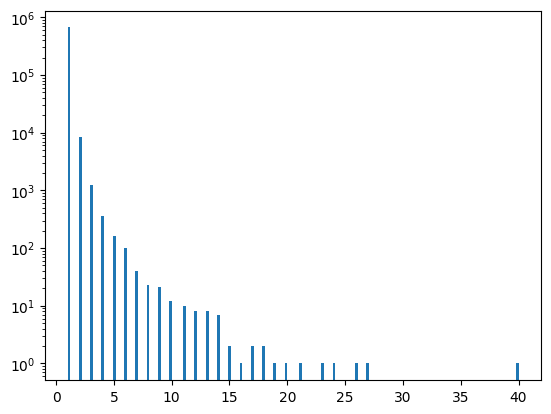

In [12]:

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
questions = list(new_data['question1']) + list(new_data['question2'])

# Initialize CountVectorizer
cv = CountVectorizer(max_features=3000)

# Fit and transform (sparse matrix)
X = cv.fit_transform(questions)  # sparse CSR matrix

# Number of original rows
n = len(new_data)

# Split into q1 and q2 (still sparse)
q1_arr = X[:n]
q2_arr = X[n:]

# Check shapes
print("q1 shape:", q1_arr.shape)
print("q2 shape:", q2_arr.shape)


q1 shape: (345033, 3000)
q2 shape: (345033, 3000)


In [14]:
from scipy.sparse import hstack

# Horizontally stack q1 and q2 (still sparse)
temp_data = hstack([q1_arr, q2_arr])

print("Shape:", temp_data.shape)  # (700000, 6000)


Shape: (345033, 6000)


In [15]:
y =data['is_duplicate'].values
y.shape

(345033,)

In [16]:
print("Length of labels y:", len(data['is_duplicate']))
print("Number of rows in q1_arr:", q1_arr.shape[0])
print("Number of rows in q2_arr:", q2_arr.shape[0])
print("Number of rows in stacked X:", X.shape[0])


Length of labels y: 345033
Number of rows in q1_arr: 345033
Number of rows in q2_arr: 345033
Number of rows in stacked X: 690066


In [17]:
X=temp_data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [18]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)



0.7981364209428029

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)



0.7302012839277174